<a href="https://colab.research.google.com/github/krishnakumarreddy007/64061_ktavva/blob/main/Assignment%2003%20Time-Series%20Data/Assignment_3_e_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting Google Drive in Google Colab**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

**Extracting a Zip File in Google Colab**

In [ ]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.zip'

# Destination directory where you want to extract the files
extracted_path = '/content/drive/MyDrive/Colab Notebooks'

# Create the destination directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)


In [ ]:
# Create the destination directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

In [ ]:
# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

**Reading and Parsing CSV Data in Google Colab**

In [ ]:
import os

# Specify the name of the CSV file
csv_filename = "jena_climate_2009_2016.csv"

# Construct the full path to the CSV file
csv_filepath = os.path.join(extracted_path, csv_filename)

# Open the CSV file and read its contents
with open(csv_filepath) as f:
    data = f.read()

# Split the data into lines
lines = data.split("\n")

# Extract header and data
header = lines[0].split(",")
lines = lines[1:]

# Print header and number of lines
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


**Plotting Temperature Data Using Matplotlib**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

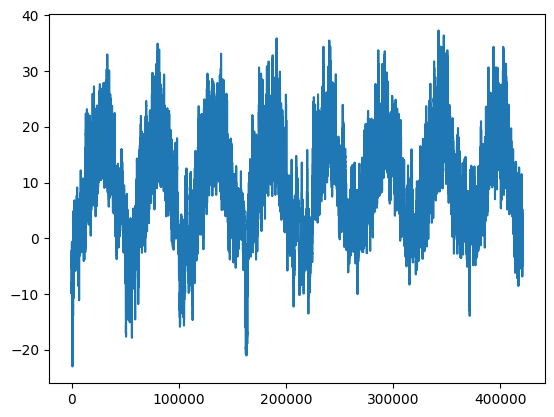

In [ ]:
 from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

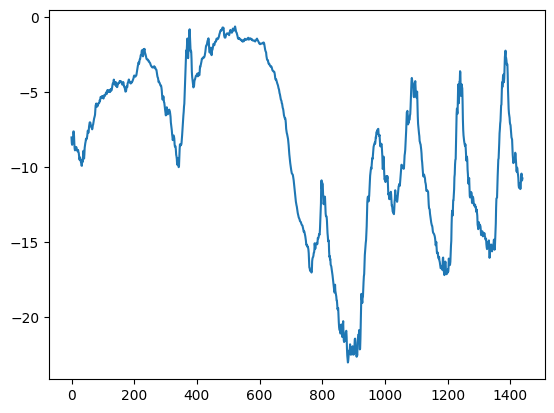

In [ ]:
plt.plot(range(1440), temperature[:1440])


**Splitting Dataset into Train, Validation, and Test Sets**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


**Standardizing Data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting Train Dataset Shapes**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**Evaluating Naive Forecast Method**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


*In simpler terms, if we were to predict future temperatures by assuming they remain the same as the current temperature, on average, we'd be off by about 2.62 degrees Celsius. This suggests that our forecasting model, while not perfect, performs better than this simplistic approach, providing more accurate predictions.*

# Basic ML Model
**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 10s 12ms/step - loss: 13.8170 - mae: 2.8712 - val_loss: 13.4401 - val_mae: 2.8987
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 9.3867 - mae: 2.4103 - val_loss: 11.5235 - val_mae: 2.6870
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.5986 - mae: 2.3100 - val_loss: 10.7952 - val_mae: 2.6039
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 8.0613 - mae: 2.2352 - val_loss: 10.6438 - val_mae: 2.5839
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.7041 - mae: 2.1848 - val_loss: 10.7836 - val_mae: 2.6074
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.3940 - mae: 2.1410 - val_loss: 10.8190 - val_mae: 2.6091
Epoch 7/10
819/819 [==============================] - 9s 10ms/step - loss: 7.1743 - mae: 2.1094 - val_loss: 11.3689 - val_mae: 2.6841
Epoch 8/10
819/819 [==============================] - 10s 1

In [ ]:
model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 8ms/step - loss: 7592.1353 - mae: 8.7682
Test MAE: 8.77


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # Tried different dense units of 8, 32, 64 apart from 16 which is given in actual code
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 11s 13ms/step - loss: 12.9909 - mae: 2.7905 - val_loss: 9.9838 - val_mae: 2.4810
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 8.6098 - mae: 2.3034 - val_loss: 13.3910 - val_mae: 2.9182
Epoch 3/10
819/819 [==============================] - 9s 10ms/step - loss: 7.4537 - mae: 2.1469 - val_loss: 10.1790 - val_mae: 2.5086
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 6.7079 - mae: 2.0388 - val_loss: 10.4051 - val_mae: 2.5377
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 6.1751 - mae: 1.9582 - val_loss: 13.4493 - val_mae: 2.9324
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 5.7787 - mae: 1.8940 - val_loss: 14.1954 - val_mae: 2.9826
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 5.4501 - mae: 1.8416 - val_loss: 11.1228 - val_mae: 2.6327
Epoch 8/10
819/819 [==============================] - 9s 

In [ ]:
model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 8ms/step - loss: 20695.4355 - mae: 14.1255
Test MAE: 14.13


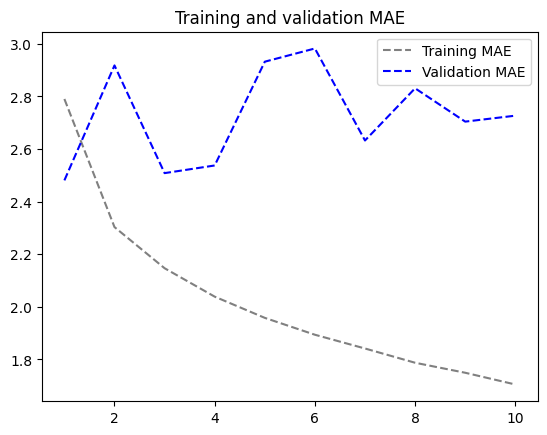

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**1D convolutional model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.conv_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.conv_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 18ms/step - loss: 24.7438 - mae: 3.8250 - val_loss: 15.8907 - val_mae: 3.1573
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.5637 - mae: 3.1329 - val_loss: 17.5031 - val_mae: 3.3315
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.4786 - mae: 3.0208 - val_loss: 14.1696 - val_mae: 2.9559
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 13.8101 - mae: 2.9483 - val_loss: 14.6745 - val_mae: 3.0154
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 13.2016 - mae: 2.8787 - val_loss: 13.5952 - val_mae: 2.8903
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 12.7366 - mae: 2.8293 - val_loss: 16.4988 - val_mae: 3.1995
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 12.2308 - mae: 2.7723 - val_loss: 13.4240 - val_mae: 2.8752
Epoch 8/10
819/819 [============================

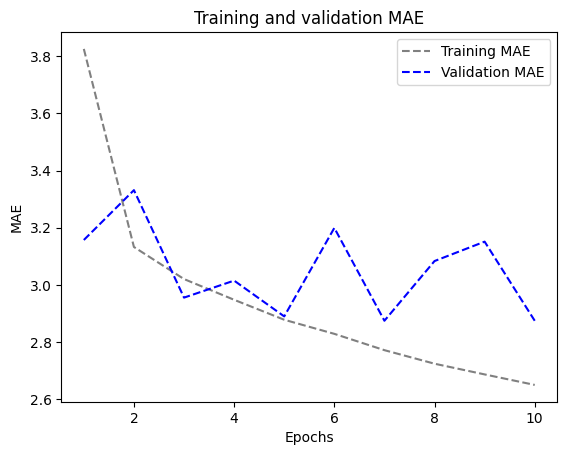

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **A Simple RNN**
**Building and Training a SimpleRNN Model**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 24ms/step - loss: 139.1070 - mae: 9.6955 - val_loss: 143.9503 - val_mae: 9.8889
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 136.3970 - mae: 9.5578 - val_loss: 143.6828 - val_mae: 9.8572
Epoch 3/10
819/819 [==============================] - 18s 21ms/step - loss: 136.3055 - mae: 9.5495 - val_loss: 143.6664 - val_mae: 9.8636
Epoch 4/10
819/819 [==============================] - 19s 24ms/step - loss: 136.3043 - mae: 9.5485 - val_loss: 143.6615 - val_mae: 9.8653
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 136.2687 - mae: 9.5474 - val_loss: 143.6505 - val_mae: 9.8649
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 136.2274 - mae: 9.5453 - val_loss: 143.5658 - val_mae: 9.8552
Epoch 7/10
819/819 [==============================] - 19s 23ms/step - loss: 136.2394 - mae: 9.5469 - val_loss: 143.6643 - val_mae: 9.8696
Epoch 8/10
819/819 [==============

**Building and Training a Stacked SimpleRNN Model**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 63s 75ms/step - loss: 136.7801 - mae: 9.5572 - val_loss: 143.3640 - val_mae: 9.8331
Epoch 2/10
819/819 [==============================] - 62s 76ms/step - loss: 135.8894 - mae: 9.5069 - val_loss: 143.3559 - val_mae: 9.8290
Epoch 3/10
819/819 [==============================] - 61s 74ms/step - loss: 135.8530 - mae: 9.5014 - val_loss: 143.3819 - val_mae: 9.8338
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 135.8423 - mae: 9.5000 - val_loss: 143.3757 - val_mae: 9.8343
Epoch 5/10
819/819 [==============================] - 61s 75ms/step - loss: 135.8247 - mae: 9.4973 - val_loss: 143.3783 - val_mae: 9.8350
Epoch 6/10
819/819 [==============================] - 61s 75ms/step - loss: 135.8137 - mae: 9.4957 - val_loss: 143.4008 - val_mae: 9.8393
Epoch 7/10
819/819 [==============================] - 61s 75ms/step - loss: 135.8039 - mae: 9.4930 - val_loss: 143.4397 - val_mae: 9.8450
Epoch 8/10
819/819 [==============

#**A Simple GRU (Gated Recurrent Unit)**


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 57ms/step - loss: 40.7857 - mae: 4.6515 - val_loss: 12.5535 - val_mae: 2.6612
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 10.6953 - mae: 2.5482 - val_loss: 9.8148 - val_mae: 2.4124
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 9.6334 - mae: 2.4293 - val_loss: 9.5324 - val_mae: 2.3855
Epoch 4/10
819/819 [==============================] - 47s 58ms/step - loss: 9.2910 - mae: 2.3830 - val_loss: 9.6428 - val_mae: 2.3932
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 9.0384 - mae: 2.3483 - val_loss: 9.5838 - val_mae: 2.3862
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 8.8291 - mae: 2.3208 - val_loss: 9.8739 - val_mae: 2.4022
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 8.6511 - mae: 2.2961 - val_loss: 9.8134 - val_mae: 2.4013
Epoch 8/10
819/819 [==============================] - 44s 5

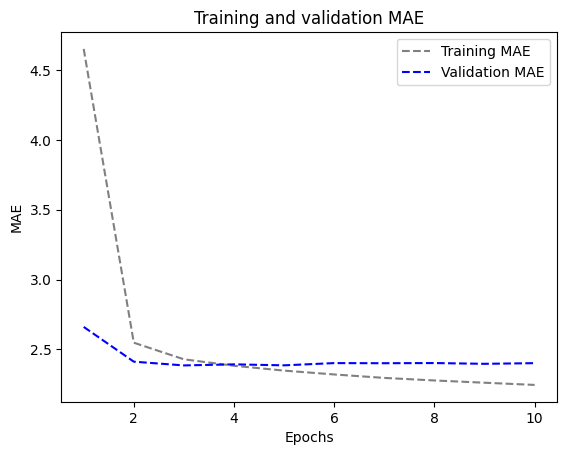

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory)**
**LSTM-Simple**


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 61ms/step - loss: 51.6417 - mae: 5.2909 - val_loss: 14.9606 - val_mae: 2.9173
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 11.7366 - mae: 2.6499 - val_loss: 10.1168 - val_mae: 2.4432
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 9.9712 - mae: 2.4669 - val_loss: 10.0722 - val_mae: 2.4640
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 9.6083 - mae: 2.4245 - val_loss: 9.7288 - val_mae: 2.4184
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 9.3938 - mae: 2.3940 - val_loss: 10.4541 - val_mae: 2.4610
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 9.1909 - mae: 2.3677 - val_loss: 10.0185 - val_mae: 2.4431
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 8.9606 - mae: 2.3369 - val_loss: 10.4512 - val_mae: 2.4711
Epoch 8/10
819/819 [==============================] - 

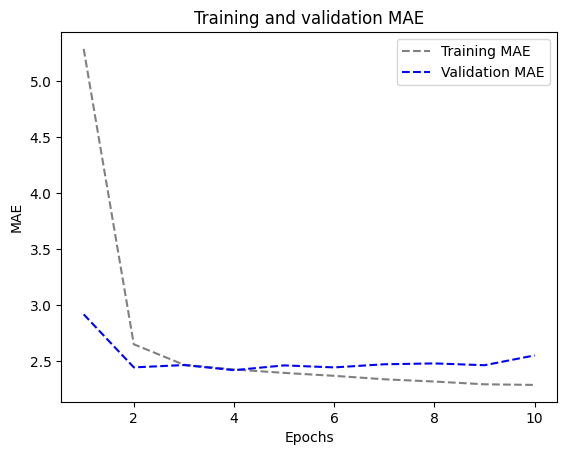

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 65s 77ms/step - loss: 50.1852 - mae: 5.2858 - val_loss: 14.1611 - val_mae: 2.8294
Epoch 2/10
819/819 [==============================] - 64s 78ms/step - loss: 20.0912 - mae: 3.4417 - val_loss: 10.0050 - val_mae: 2.4554
Epoch 3/10
819/819 [==============================] - 64s 78ms/step - loss: 18.2370 - mae: 3.2880 - val_loss: 9.5489 - val_mae: 2.4122
Epoch 4/10
819/819 [==============================] - 65s 80ms/step - loss: 17.3612 - mae: 3.2104 - val_loss: 10.1190 - val_mae: 2.4684
Epoch 5/10
819/819 [==============================] - 64s 78ms/step - loss: 16.6826 - mae: 3.1441 - val_loss: 9.5185 - val_mae: 2.4141
Epoch 6/10
819/819 [==============================] - 64s 78ms/step - loss: 16.2288 - mae: 3.1036 - val_loss: 9.5455 - val_mae: 2.4062
Epoch 7/10
819/819 [==============================] - 65s 79ms/step - loss: 15.8438 - mae: 3.0699 - val_loss: 9.7720 - val_mae: 2.4416
Epoch 8/10
819/819 [==============================] 

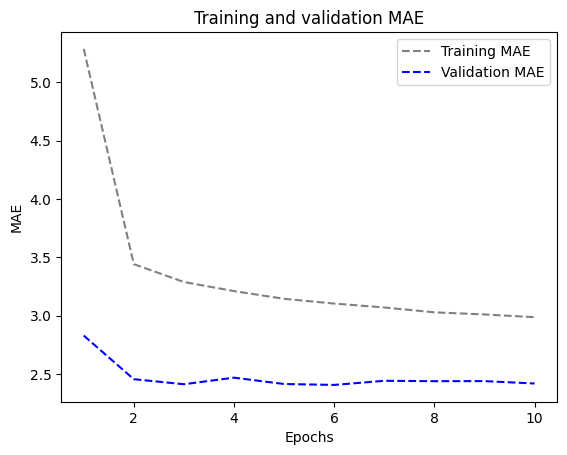

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 16 units**


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 97s 115ms/step - loss: 37.8961 - mae: 4.4606 - val_loss: 12.1592 - val_mae: 2.6569
Epoch 2/10
819/819 [==============================] - 98s 119ms/step - loss: 9.8904 - mae: 2.4410 - val_loss: 9.9203 - val_mae: 2.4560
Epoch 3/10
819/819 [==============================] - 99s 121ms/step - loss: 8.4758 - mae: 2.2768 - val_loss: 9.7920 - val_mae: 2.4478
Epoch 4/10
819/819 [==============================] - 102s 125ms/step - loss: 7.7877 - mae: 2.1894 - val_loss: 10.8092 - val_mae: 2.5380
Epoch 5/10
819/819 [==============================] - 93s 114ms/step - loss: 7.3121 - mae: 2.1202 - val_loss: 10.9703 - val_mae: 2.5493
Epoch 6/10
819/819 [==============================] - 99s 120ms/step - loss: 6.9092 - mae: 2.0598 - val_loss: 11.1217 - val_mae: 2.5878
Epoch 7/10
819/819 [==============================] - 97s 118ms/step - loss: 6.5779 - mae: 2.0100 - val_loss: 11.1886 - val_mae: 2.5978
Epoch 8/10
819/819 [============================

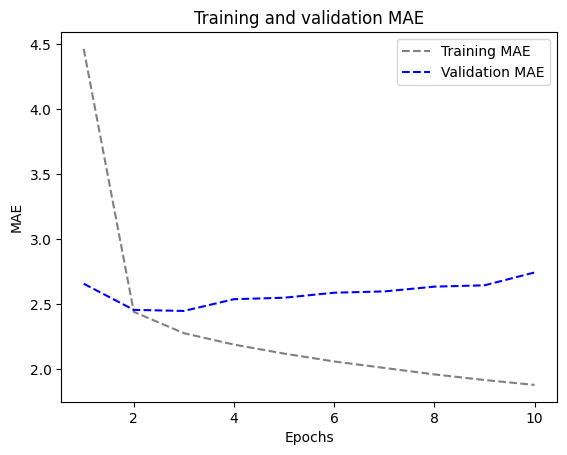

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 151s 180ms/step - loss: 19.9998 - mae: 3.2178 - val_loss: 9.8595 - val_mae: 2.4652
Epoch 2/10
819/819 [==============================] - 147s 179ms/step - loss: 8.0065 - mae: 2.2055 - val_loss: 10.0614 - val_mae: 2.4669
Epoch 3/10
819/819 [==============================] - 147s 179ms/step - loss: 6.4192 - mae: 1.9671 - val_loss: 11.4165 - val_mae: 2.6500
Epoch 4/10
819/819 [==============================] - 149s 182ms/step - loss: 5.2497 - mae: 1.7771 - val_loss: 12.4365 - val_mae: 2.7601
Epoch 5/10
819/819 [==============================] - 149s 182ms/step - loss: 4.3403 - mae: 1.6120 - val_loss: 12.6619 - val_mae: 2.7872
Epoch 6/10
819/819 [==============================] - 148s 181ms/step - loss: 3.7004 - mae: 1.4817 - val_loss: 13.2119 - val_mae: 2.8523
Epoch 7/10
819/819 [==============================] - 149s 182ms/step - loss: 3.2569 - mae: 1.3850 - val_loss: 13.2095 - val_mae: 2.8732
Epoch 8/10
819/819 [=====================

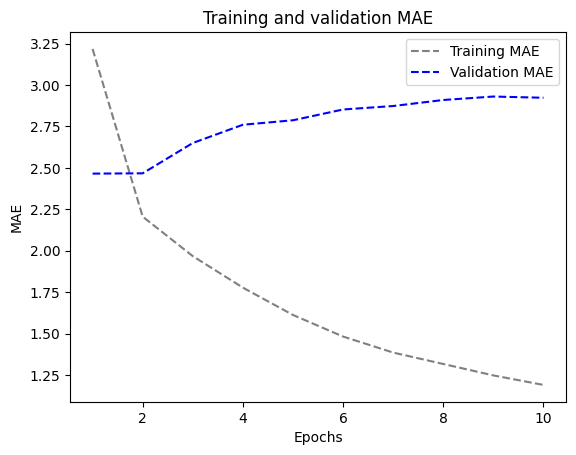

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 76s 89ms/step - loss: 65.9834 - mae: 6.1814 - val_loss: 30.9743 - val_mae: 4.1141
Epoch 2/10
819/819 [==============================] - 71s 87ms/step - loss: 19.3115 - mae: 3.2646 - val_loss: 12.1540 - val_mae: 2.6369
Epoch 3/10
819/819 [==============================] - 69s 85ms/step - loss: 11.0318 - mae: 2.5698 - val_loss: 9.9933 - val_mae: 2.4563
Epoch 4/10
819/819 [==============================] - 79s 97ms/step - loss: 9.9930 - mae: 2.4587 - val_loss: 10.9304 - val_mae: 2.4984
Epoch 5/10
819/819 [==============================] - 73s 89ms/step - loss: 9.5746 - mae: 2.4098 - val_loss: 9.7733 - val_mae: 2.4222
Epoch 6/10
819/819 [==============================] - 77s 93ms/step - loss: 9.3363 - mae: 2.3802 - val_loss: 9.7486 - val_mae: 2.4132
Epoch 7/10
819/819 [==============================] - 74s 91ms/step - loss: 9.2047 - mae: 2.3627 - val_loss: 9.5123 - val_mae: 2.3828
Epoch 8/10
819/819 [==============================] - 76

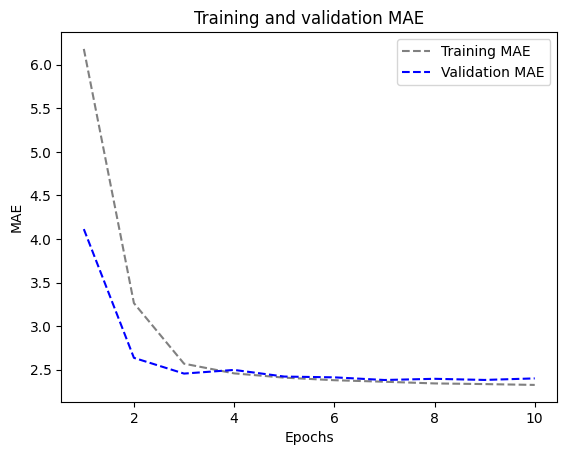

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 123s 144ms/step - loss: 76.8215 - mae: 6.7668 - val_loss: 38.4445 - val_mae: 4.6585
Epoch 2/10
819/819 [==============================] - 117s 143ms/step - loss: 33.2560 - mae: 4.3124 - val_loss: 14.8314 - val_mae: 2.8883
Epoch 3/10
819/819 [==============================] - 118s 144ms/step - loss: 24.8671 - mae: 3.7799 - val_loss: 11.6615 - val_mae: 2.6309
Epoch 4/10
819/819 [==============================] - 117s 143ms/step - loss: 22.6982 - mae: 3.6192 - val_loss: 11.0985 - val_mae: 2.5893
Epoch 5/10
819/819 [==============================] - 116s 142ms/step - loss: 21.4513 - mae: 3.5224 - val_loss: 10.5277 - val_mae: 2.5294
Epoch 6/10
819/819 [==============================] - 117s 143ms/step - loss: 20.3581 - mae: 3.4360 - val_loss: 10.4164 - val_mae: 2.5209
Epoch 7/10
819/819 [==============================] - 115s 140ms/step - loss: 19.5736 - mae: 3.3701 - val_loss: 9.9623 - val_mae: 2.4647
Epoch 8/10
819/819 [===============

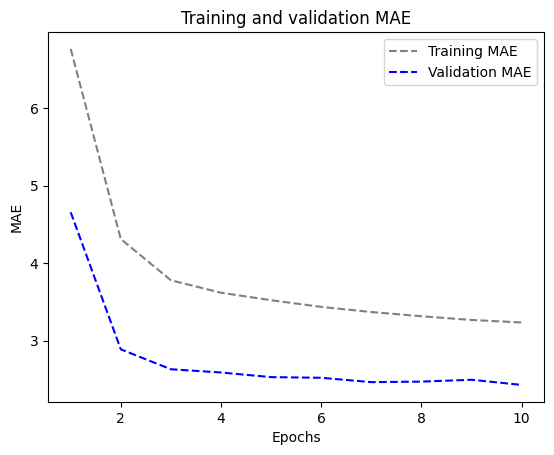

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **Bidirectional LSTM**


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 70ms/step - loss: 26.3899 - mae: 3.6825 - val_loss: 10.2591 - val_mae: 2.4846
Epoch 2/10
819/819 [==============================] - 56s 69ms/step - loss: 9.6255 - mae: 2.4143 - val_loss: 9.3603 - val_mae: 2.3791
Epoch 3/10
819/819 [==============================] - 57s 69ms/step - loss: 8.6170 - mae: 2.2885 - val_loss: 9.0039 - val_mae: 2.3318
Epoch 4/10
819/819 [==============================] - 57s 70ms/step - loss: 8.0183 - mae: 2.2057 - val_loss: 9.1478 - val_mae: 2.3551
Epoch 5/10
819/819 [==============================] - 56s 68ms/step - loss: 7.5361 - mae: 2.1405 - val_loss: 9.1695 - val_mae: 2.3362
Epoch 6/10
819/819 [==============================] - 57s 70ms/step - loss: 7.2256 - mae: 2.0934 - val_loss: 9.5240 - val_mae: 2.3803
Epoch 7/10
819/819 [==============================] - 56s 69ms/step - loss: 7.0406 - mae: 2.0642 - val_loss: 9.8744 - val_mae: 2.4252
Epoch 8/10
819/819 [==============================] - 56s 69

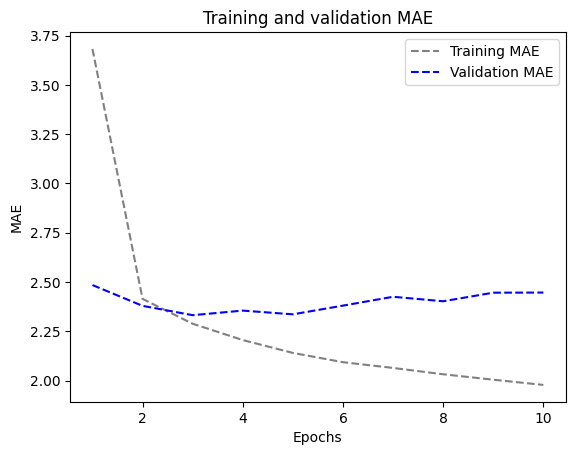

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

#**1D Convnets and LSTM togther**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 17ms/step - loss: 52.3809 - mae: 5.4177 - val_loss: 26.9044 - val_mae: 3.9981
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 18.1475 - mae: 3.2918 - val_loss: 21.9826 - val_mae: 3.7402
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.9231 - mae: 3.0037 - val_loss: 21.4129 - val_mae: 3.6806
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 13.2432 - mae: 2.8230 - val_loss: 21.5409 - val_mae: 3.6680
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 11.9695 - mae: 2.6788 - val_loss: 22.2323 - val_mae: 3.7742
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 11.0755 - mae: 2.5661 - val_loss: 22.2071 - val_mae: 3.7436
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 10.3190 - mae: 2.4717 - val_loss: 23.2908 - val_mae: 3.8533
Epoch 8/10
819/819 [============================

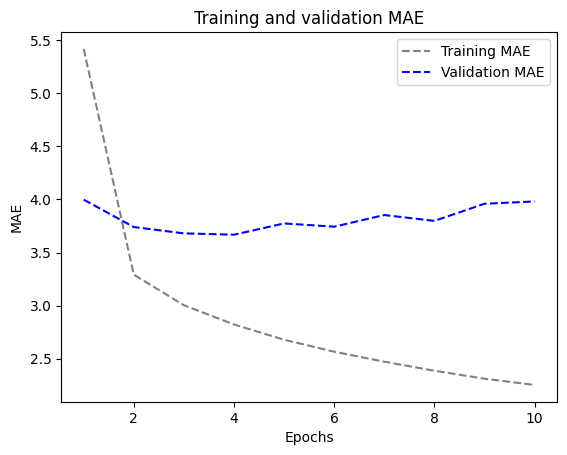

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

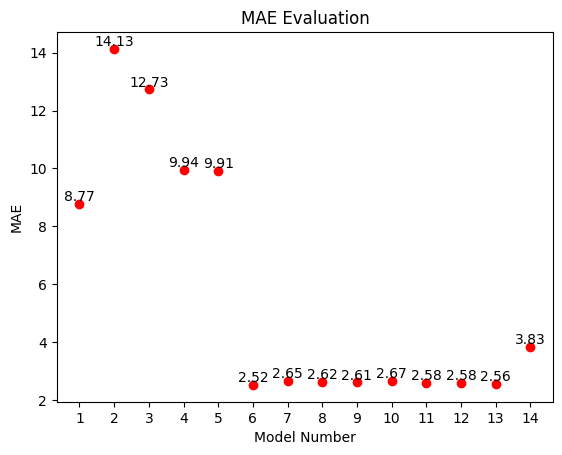

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (8.77,14.13,12.73,9.94,9.91,2.52,2.65,2.62,2.61,2.67,2.58,2.58,2.56,3.83)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()